***
# <a id='toc1_'></a>[Model Preparation: NCAA Men's March Madness](#toc0_)
***

**Table of contents**<a id='toc0_'></a>    
- [Model Preparation: NCAA Men's March Madness](#toc1_)    
  - [Imports & Global Settings](#toc1_1_)    
  - [Tournament Seeding](#toc1_2_)    
    - [**Play-In Games & Their Impact on Seeding**](#toc1_2_1_)    
    - [**Automatic Qualifiers vs. At-Large Teams:**](#toc1_2_2_)    
    - [Tournament Matchups](#toc1_2_3_)    
  - [Matchup Features](#toc1_3_)    
    - [Conferences](#toc1_3_1_)    
    - [Tournament Representation Over Time: Power vs. Non-Power Conferences](#toc1_3_2_)    
    - [Tournament Representation / Team Composition](#toc1_3_3_)    
  - [Model Preparation](#toc1_4_)    
  - [Model Preparation: Defining Conference Type](#toc1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Imports & Global Settings](#toc0_)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from Utils import *

In [ ]:
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
jimmer = 32 # Jimmer Fredette for randomizaion
duke = 1181 # TeamID for Duke to use for reference / debugging

***
## <a id='toc1_2_'></a>[Tournament Seeding](#toc0_)
***

In [ ]:
# Load in Tournament Info
teams = pd.read_csv('./Data/Mteams.csv', dtype={'TeamID': str}).set_index('TeamID')['TeamName']
tournament_seeds = pd.read_csv('./Data/MNCAATourneySeeds.csv', dtype={'TeamID': str})
display(tournament_seeds)

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
...,...,...,...
2621,2025,Z12,1161
2622,2025,Z13,1213
2623,2025,Z14,1423
2624,2025,Z15,1303


In [4]:
tournament_seeds['TeamName'] = tournament_seeds['TeamID'].map(teams)
display(tournament_seeds)

,Season,Seed,TeamID,TeamName
0,1985,W01,1207,Georgetown
1,1985,W02,1210,Georgia Tech
2,1985,W03,1228,Illinois
3,1985,W04,1260,Loyola-Chicago
4,1985,W05,1374,SMU
...,...,...,...,...
2621,2025,Z12,1161,Colorado St
2622,2025,Z13,1213,Grand Canyon
2623,2025,Z14,1423,UNC Wilmington
2624,2025,Z15,1303,NE Omaha


In [5]:
print(tournament_seeds['Seed'].sample(5))
print("--------------------------")
print(tournament_seeds['Seed'].str[0].unique())

2515     X10
2275     Z06
2123     Y08
2099    W16b
304      Z01
Name: Seed, dtype: object
--------------------------
['W' 'X' 'Y' 'Z']


As part of the seeding process and bracket formation, the tournament field is divided into four (4) regions—`W`, `X`, `Y`, and `Z`—each containing seeds **1 through 16** (e.g., `W01` = #1 Seed in `RegionW`; `Z12` = #12 seed in `RegionZ`, etc.).


Whichever region’s name comes first alphabetically is assigned to `RegionW`. The region that plays against `RegionW` in the national semifinals (*The Final Four*)—or is positioned on the **same side of the bracket**—is assigned to `RegionX`.  

For the other two regions, the one that comes first alphabetically is assigned to `RegionY`, and the remaining region is assigned to `RegionZ`.  

This standardized naming ensures consistency, even if the official region names change from year to year.

In [6]:
tournament_seeds['Region'] = tournament_seeds['Seed'].str[0]
tournament_seeds['SeedNum'] = tournament_seeds['Seed'].str[1:]
tournament_seeds

,Season,Seed,TeamID,TeamName,Region,SeedNum
0,1985,W01,1207,Georgetown,W,01
1,1985,W02,1210,Georgia Tech,W,02
2,1985,W03,1228,Illinois,W,03
3,1985,W04,1260,Loyola-Chicago,W,04
4,1985,W05,1374,SMU,W,05
...,...,...,...,...,...,...
2621,2025,Z12,1161,Colorado St,Z,12
2622,2025,Z13,1213,Grand Canyon,Z,13
2623,2025,Z14,1423,UNC Wilmington,Z,14
2624,2025,Z15,1303,NE Omaha,Z,15


In [7]:
tournament_seeds['SeedNum'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '16a', '16b', '12a', '12b', '11a',
       '11b', '14a', '14b', '13a', '13b', '10a', '10b'], dtype=object)

In [ ]:
tournament_seeds[tournament_seeds['SeedNum'].str.contains('a|b')]

,Season,Seed,TeamID,TeamName,Region,SeedNum
1071,2001,Y16a,1322,Northwestern LA,Y,16a
1072,2001,Y16b,1457,Winthrop,Y,16b
1104,2002,W16a,1108,Alcorn St,W,16a
1105,2002,W16b,1373,Siena,W,16b
1185,2003,X16a,1411,TX Southern,X,16a
...,...,...,...,...,...,...
2586,2025,X11b,1462,Xavier,X,11b
2602,2025,Y11a,1314,North Carolina,Y,11a
2603,2025,Y11b,1361,San Diego St,Y,11b
2608,2025,Y16a,1106,Alabama St,Y,16a


### <a id='toc1_2_1_'></a>[**Play-In Games & Their Impact on Seeding**](#toc0_)
***

In **2011**, the NCAA introduced the **First Four** format, expanding the tournament to **68 teams**. This created **four play-in games**, where teams compete for a spot in the **64-team bracket**.

The **First Four** consists of:
- **Two games between the lowest-seeded automatic qualifiers**, playing for a **16 seed**.
- **Two games between the lowest-seeded at-large teams**, competing for a **higher seed** (e.g., an 11 or 12 seed).  

***

### <a id='toc1_2_2_'></a>[**Automatic Qualifiers vs. At-Large Teams:**](#toc0_)
- **Automatic Qualifiers** – Teams that earn a bid to the NCAA Tournament by **winning their conference tournament**. Each of the **32 Division I conferences** receives **one automatic bid**.
- **At-Large Teams** – Teams that did ****NOT**** win their conference tournament but are selected by the **NCAA Selection Committee** based on their overall performance. The remaining **36 spots** in the tournament are filled by at-large teams.

Since play-in teams share the **same numerical seed**, an **additional letter (`a` or `b`)** is assigned to differentiate them:
- The **"a" team** is assigned to the school with the **lower Team ID**.
- The **"b" team** is assigned to the other play-in team at the same seed level.

This ensures that **each team has a unique identifier** while maintaining the traditional seeding structure, but for the purposes of our model, the additional letters can be dropped.

In [ ]:
tournament_seeds['SeedNum'] = tournament_seeds['SeedNum'].str.replace('a', '').str.replace('b', '').astype(int)
tournament_seeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2626 entries, 0 to 2625
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Season    2626 non-null   int64 
 1   Seed      2626 non-null   object
 2   TeamID    2626 non-null   object
 3   TeamName  2626 non-null   object
 4   Region    2626 non-null   object
 5   SeedNum   2626 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 123.2+ KB


In [10]:
# Load in data from Data_Collection notebook
regular_season_stats = pd.read_csv('./Data/Live/RegularSeasonStats.csv', dtype={'TeamID': str})

In [11]:
# Merge Seed data onto regular season stats
regular_season_stats = regular_season_stats.merge(
    tournament_seeds[['Season', 'TeamID', 'Seed', 'Region', 'SeedNum']],
    on=['Season', 'TeamID'],
    how='left'
)

In [12]:
regular_season_stats.head()

,Season,TeamID,TeamName,ConfAbbrev,Description,TotalGames,TotalWins,TotalLosses,WinningPercentage,Score_PerGame,OppScore_PerGame,NumOT_PerGame,FGM_PerGame,FGA_PerGame,FGM3_PerGame,FGA3_PerGame,FTM_PerGame,FTA_PerGame,OR_PerGame,DR_PerGame,Ast_PerGame,TO_PerGame,Stl_PerGame,Blk_PerGame,PF_PerGame,OppFGM_PerGame,OppFGA_PerGame,OppFGM3_PerGame,OppFGA3_PerGame,OppFTM_PerGame,OppFTA_PerGame,OppOR_PerGame,OppDR_PerGame,OppAst_PerGame,OppTO_PerGame,OppStl_PerGame,OppBlk_PerGame,OppPF_PerGame,Win_PerGame,FG_Percentage_PerGame,FG3_Percentage_PerGame,FT_Percentage_PerGame,Ast_TO_Ratio_PerGame,OppFG_Percentage_PerGame,OppFG3_Percentage_PerGame,OppFT_Percentage_PerGame,OppAst_TO_Ratio_PerGame,Poss_PerGame,OppPoss_PerGame,OffEff_PerGame,DefEff_PerGame,OppOffEff_PerGame,OppDefEff_PerGame,Score_Diff_PerGame,FGM_Diff_PerGame,FGA_Diff_PerGame,FGM3_Diff_PerGame,FGA3_Diff_PerGame,FTM_Diff_PerGame,FTA_Diff_PerGame,OR_Diff_PerGame,DR_Diff_PerGame,Ast_Diff_PerGame,TO_Diff_PerGame,Stl_Diff_PerGame,Blk_Diff_PerGame,PF_Diff_PerGame,Poss_Diff_PerGame,OffEff_Diff_PerGame,DefEff_Diff_PerGame,Score_Diff_Pct_PerGame,FGM_Diff_Pct_PerGame,FGA_Diff_Pct_PerGame,FGM3_Diff_Pct_PerGame,FGA3_Diff_Pct_PerGame,FTM_Diff_Pct_PerGame,FTA_Diff_Pct_PerGame,OR_Diff_Pct_PerGame,DR_Diff_Pct_PerGame,Ast_Diff_Pct_PerGame,TO_Diff_Pct_PerGame,Stl_Diff_Pct_PerGame,Blk_Diff_Pct_PerGame,PF_Diff_Pct_PerGame,Poss_Diff_Pct_PerGame,OffEff_Diff_Pct_PerGame,DefEff_Diff_Pct_PerGame,Score_Diff_Opp_PerGame,FGM_Diff_Opp_PerGame,FGA_Diff_Opp_PerGame,FGM3_Diff_Opp_PerGame,FGA3_Diff_Opp_PerGame,FTM_Diff_Opp_PerGame,FTA_Diff_Opp_PerGame,OR_Diff_Opp_PerGame,DR_Diff_Opp_PerGame,Ast_Diff_Opp_PerGame,TO_Diff_Opp_PerGame,Stl_Diff_Opp_PerGame,Blk_Diff_Opp_PerGame,PF_Diff_Opp_PerGame,Poss_Diff_Opp_PerGame,OffEff_Diff_Opp_PerGame,DefEff_Diff_Opp_PerGame,Score_Diff_Pct_Opp_PerGame,FGM_Diff_Pct_Opp_PerGame,FGA_Diff_Pct_Opp_PerGame,FGM3_Diff_Pct_Opp_PerGame,FGA3_Diff_Pct_Opp_PerGame,FTM_Diff_Pct_Opp_PerGame,FTA_Diff_Pct_Opp_PerGame,OR_Diff_Pct_Opp_PerGame,DR_Diff_Pct_Opp_PerGame,Ast_Diff_Pct_Opp_PerGame,TO_Diff_Pct_Opp_PerGame,Stl_Diff_Pct_Opp_PerGame,Blk_Diff_Pct_Opp_PerGame,PF_Diff_Pct_Opp_PerGame,Poss_Diff_Pct_Opp_PerGame,OffEff_Diff_Pct_Opp_PerGame,DefEff_Diff_Pct_Opp_PerGame,KenPomRank_PerGame,OppKenPomRank_PerGame,KenPomDiff_PerGame,OppKenPomDiff_PerGame,Score_PerWin,OppScore_PerWin,NumOT_PerWin,FGM_PerWin,FGA_PerWin,FGM3_PerWin,FGA3_PerWin,FTM_PerWin,FTA_PerWin,OR_PerWin,DR_PerWin,Ast_PerWin,TO_PerWin,Stl_PerWin,Blk_PerWin,PF_PerWin,OppFGM_PerWin,OppFGA_PerWin,OppFGM3_PerWin,OppFGA3_PerWin,OppFTM_PerWin,OppFTA_PerWin,OppOR_PerWin,OppDR_PerWin,OppAst_PerWin,OppTO_PerWin,OppStl_PerWin,OppBlk_PerWin,OppPF_PerWin,Win_PerWin,FG_Percentage_PerWin,FG3_Percentage_PerWin,FT_Percentage_PerWin,Ast_TO_Ratio_PerWin,OppFG_Percentage_PerWin,OppFG3_Percentage_PerWin,OppFT_Percentage_PerWin,OppAst_TO_Ratio_PerWin,Poss_PerWin,OppPoss_PerWin,OffEff_PerWin,DefEff_PerWin,OppOffEff_PerWin,OppDefEff_PerWin,Score_Diff_PerWin,FGM_Diff_PerWin,FGA_Diff_PerWin,FGM3_Diff_PerWin,FGA3_Diff_PerWin,FTM_Diff_PerWin,FTA_Diff_PerWin,OR_Diff_PerWin,DR_Diff_PerWin,Ast_Diff_PerWin,TO_Diff_PerWin,Stl_Diff_PerWin,Blk_Diff_PerWin,PF_Diff_PerWin,Poss_Diff_PerWin,OffEff_Diff_PerWin,DefEff_Diff_PerWin,Score_Diff_Pct_PerWin,FGM_Diff_Pct_PerWin,FGA_Diff_Pct_PerWin,FGM3_Diff_Pct_PerWin,FGA3_Diff_Pct_PerWin,FTM_Diff_Pct_PerWin,FTA_Diff_Pct_PerWin,OR_Diff_Pct_PerWin,DR_Diff_Pct_PerWin,Ast_Diff_Pct_PerWin,TO_Diff_Pct_PerWin,Stl_Diff_Pct_PerWin,Blk_Diff_Pct_PerWin,PF_Diff_Pct_PerWin,Poss_Diff_Pct_PerWin,OffEff_Diff_Pct_PerWin,DefEff_Diff_Pct_PerWin,Score_Diff_Opp_PerWin,FGM_Diff_Opp_PerWin,FGA_Diff_Opp_PerWin,FGM3_Diff_Opp_PerWin,FGA3_Diff_Opp_PerWin,FTM_Diff_Opp_PerWin,FTA_Diff_Opp_PerWin,OR_Diff_Opp_PerWin,DR_Diff_Opp_PerWin,Ast_Diff_Opp_PerWin,TO_Diff_Opp_PerWin,Stl_Diff_Opp_PerWin,Blk_Diff_Opp_PerWin,PF_Diff_Opp_PerWin,Poss_Diff_Opp_PerWin,OffEff_Diff_Opp_PerWin,DefEff_Diff_Opp_PerWin,Score_Diff_Pct_Opp_PerWin,FGM_Diff_Pct_Opp_PerWin,FGA_Diff_Pc

Since only 64 teams make the tournament, there will be a large number of missing values for those teams that did ***not*** make the bracket.

In [ ]:
regular_season_stats.tail()

,Season,TeamID,TeamName,ConfAbbrev,Description,TotalGames,TotalWins,TotalLosses,WinningPercentage,Score_PerGame,OppScore_PerGame,NumOT_PerGame,FGM_PerGame,FGA_PerGame,FGM3_PerGame,FGA3_PerGame,FTM_PerGame,FTA_PerGame,OR_PerGame,DR_PerGame,Ast_PerGame,TO_PerGame,Stl_PerGame,Blk_PerGame,PF_PerGame,OppFGM_PerGame,OppFGA_PerGame,OppFGM3_PerGame,OppFGA3_PerGame,OppFTM_PerGame,OppFTA_PerGame,OppOR_PerGame,OppDR_PerGame,OppAst_PerGame,OppTO_PerGame,OppStl_PerGame,OppBlk_PerGame,OppPF_PerGame,Win_PerGame,FG_Percentage_PerGame,FG3_Percentage_PerGame,FT_Percentage_PerGame,Ast_TO_Ratio_PerGame,OppFG_Percentage_PerGame,OppFG3_Percentage_PerGame,OppFT_Percentage_PerGame,OppAst_TO_Ratio_PerGame,Poss_PerGame,OppPoss_PerGame,OffEff_PerGame,DefEff_PerGame,OppOffEff_PerGame,OppDefEff_PerGame,Score_Diff_PerGame,FGM_Diff_PerGame,FGA_Diff_PerGame,FGM3_Diff_PerGame,FGA3_Diff_PerGame,FTM_Diff_PerGame,FTA_Diff_PerGame,OR_Diff_PerGame,DR_Diff_PerGame,Ast_Diff_PerGame,TO_Diff_PerGame,Stl_Diff_PerGame,Blk_Diff_PerGame,PF_Diff_PerGame,Poss_Diff_PerGame,OffEff_Diff_PerGame,DefEff_Diff_PerGame,Score_Diff_Pct_PerGame,FGM_Diff_Pct_PerGame,FGA_Diff_Pct_PerGame,FGM3_Diff_Pct_PerGame,FGA3_Diff_Pct_PerGame,FTM_Diff_Pct_PerGame,FTA_Diff_Pct_PerGame,OR_Diff_Pct_PerGame,DR_Diff_Pct_PerGame,Ast_Diff_Pct_PerGame,TO_Diff_Pct_PerGame,Stl_Diff_Pct_PerGame,Blk_Diff_Pct_PerGame,PF_Diff_Pct_PerGame,Poss_Diff_Pct_PerGame,OffEff_Diff_Pct_PerGame,DefEff_Diff_Pct_PerGame,Score_Diff_Opp_PerGame,FGM_Diff_Opp_PerGame,FGA_Diff_Opp_PerGame,FGM3_Diff_Opp_PerGame,FGA3_Diff_Opp_PerGame,FTM_Diff_Opp_PerGame,FTA_Diff_Opp_PerGame,OR_Diff_Opp_PerGame,DR_Diff_Opp_PerGame,Ast_Diff_Opp_PerGame,TO_Diff_Opp_PerGame,Stl_Diff_Opp_PerGame,Blk_Diff_Opp_PerGame,PF_Diff_Opp_PerGame,Poss_Diff_Opp_PerGame,OffEff_Diff_Opp_PerGame,DefEff_Diff_Opp_PerGame,Score_Diff_Pct_Opp_PerGame,FGM_Diff_Pct_Opp_PerGame,FGA_Diff_Pct_Opp_PerGame,FGM3_Diff_Pct_Opp_PerGame,FGA3_Diff_Pct_Opp_PerGame,FTM_Diff_Pct_Opp_PerGame,FTA_Diff_Pct_Opp_PerGame,OR_Diff_Pct_Opp_PerGame,DR_Diff_Pct_Opp_PerGame,Ast_Diff_Pct_Opp_PerGame,TO_Diff_Pct_Opp_PerGame,Stl_Diff_Pct_Opp_PerGame,Blk_Diff_Pct_Opp_PerGame,PF_Diff_Pct_Opp_PerGame,Poss_Diff_Pct_Opp_PerGame,OffEff_Diff_Pct_Opp_PerGame,DefEff_Diff_Pct_Opp_PerGame,KenPomRank_PerGame,OppKenPomRank_PerGame,KenPomDiff_PerGame,OppKenPomDiff_PerGame,Score_PerWin,OppScore_PerWin,NumOT_PerWin,FGM_PerWin,FGA_PerWin,FGM3_PerWin,FGA3_PerWin,FTM_PerWin,FTA_PerWin,OR_PerWin,DR_PerWin,Ast_PerWin,TO_PerWin,Stl_PerWin,Blk_PerWin,PF_PerWin,OppFGM_PerWin,OppFGA_PerWin,OppFGM3_PerWin,OppFGA3_PerWin,OppFTM_PerWin,OppFTA_PerWin,OppOR_PerWin,OppDR_PerWin,OppAst_PerWin,OppTO_PerWin,OppStl_PerWin,OppBlk_PerWin,OppPF_PerWin,Win_PerWin,FG_Percentage_PerWin,FG3_Percentage_PerWin,FT_Percentage_PerWin,Ast_TO_Ratio_PerWin,OppFG_Percentage_PerWin,OppFG3_Percentage_PerWin,OppFT_Percentage_PerWin,OppAst_TO_Ratio_PerWin,Poss_PerWin,OppPoss_PerWin,OffEff_PerWin,DefEff_PerWin,OppOffEff_PerWin,OppDefEff_PerWin,Score_Diff_PerWin,FGM_Diff_PerWin,FGA_Diff_PerWin,FGM3_Diff_PerWin,FGA3_Diff_PerWin,FTM_Diff_PerWin,FTA_Diff_PerWin,OR_Diff_PerWin,DR_Diff_PerWin,Ast_Diff_PerWin,TO_Diff_PerWin,Stl_Diff_PerWin,Blk_Diff_PerWin,PF_Diff_PerWin,Poss_Diff_PerWin,OffEff_Diff_PerWin,DefEff_Diff_PerWin,Score_Diff_Pct_PerWin,FGM_Diff_Pct_PerWin,FGA_Diff_Pct_PerWin,FGM3_Diff_Pct_PerWin,FGA3_Diff_Pct_PerWin,FTM_Diff_Pct_PerWin,FTA_Diff_Pct_PerWin,OR_Diff_Pct_PerWin,DR_Diff_Pct_PerWin,Ast_Diff_Pct_PerWin,TO_Diff_Pct_PerWin,Stl_Diff_Pct_PerWin,Blk_Diff_Pct_PerWin,PF_Diff_Pct_PerWin,Poss_Diff_Pct_PerWin,OffEff_Diff_Pct_PerWin,DefEff_Diff_Pct_PerWin,Score_Diff_Opp_PerWin,FGM_Diff_Opp_PerWin,FGA_Diff_Opp_PerWin,FGM3_Diff_Opp_PerWin,FGA3_Diff_Opp_PerWin,FTM_Diff_Opp_PerWin,FTA_Diff_Opp_PerWin,OR_Diff_Opp_PerWin,DR_Diff_Opp_PerWin,Ast_Diff_Opp_PerWin,TO_Diff_Opp_PerWin,Stl_Diff_Opp_PerWin,Blk_Diff_Opp_PerWin,PF_Diff_Opp_PerWin,Poss_Diff_Opp_PerWin,OffEff_Diff_Opp_PerWin,DefEff_Diff_Opp_PerWin,Score_Diff_Pct_Opp_PerWin,FGM_Diff_Pct_Opp_PerWin,FGA_Diff_Pc

***
### <a id='toc1_2_3_'></a>[Tournament Matchups](#toc0_)

- Using the `MNCAATourneyCompactResults.csv`, we will reshape the dataset into the same format as done previously, creating two (2) records per game with the `WTeamID` and `LTeamID` as the the main `TeamID`.
- The the regular season features will be merged on the `TeamID` and `OppTeamID` to get a robust set of features to train our model on.
- This will result in a binary classification problem for each game, with the target being the `'Win'` column (`win=1` | `loss = 0`).

***

In [ ]:
tournament_results = pd.read_csv('./Data/MNCAATourneyCompactResults.csv', dtype={
    'WTeamID':str,
    'LTeamID': str}
    )

In [15]:
print(tournament_results.shape)
display(tournament_results.head())
print(tournament_results.info())

(2518, 8)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Season   2518 non-null   int64 
 1   DayNum   2518 non-null   int64 
 2   WTeamID  2518 non-null   object
 3   WScore   2518 non-null   int64 
 4   LTeamID  2518 non-null   object
 5   LScore   2518 non-null   int64 
 6   WLoc     2518 non-null   object
 7   NumOT    2518 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 157.5+ KB
None


In [16]:
max_tourney_season = tournament_results['Season'].max()
min_tourney_season = tournament_results['Season'].min()

max_season = regular_season_stats['Season'].max()
min_season = regular_season_stats['Season'].min()

print(f"Regular season results for last {regular_season_stats['Season'].nunique()} seasons ({min_season} - {max_season}).")
print(f"Tournament results for last {tournament_results['Season'].nunique()} seasons ({min_tourney_season} - {max_tourney_season}). No tournament in 2020 due to COVID-19.")

Regular season results for last 23 seasons (2003 - 2025).
Tournament results for last 39 seasons (1985 - 2024). No tournament in 2020 due to COVID-19.


Given the regular season data only contains information from `2003` onwards, we'll match the tournament dataset for the same.

In [17]:
tournament_results = tournament_results[tournament_results['Season'] >= 2003].reset_index(drop=True).copy()

In [18]:
df_team_tourney_results = pd.concat(
    [
        tournament_results
        .assign(GameResult="W")
        .rename(columns={"WTeamID": "TeamID", 
                         "LTeamID": "OppTeamID", 
                         "WScore": "TeamScore", 
                         "LScore": "OppScore"}),
        
        tournament_results
        .assign(GameResult="L")
        .rename(columns={"LTeamID": "TeamID", 
                         "WTeamID": "OppTeamID", 
                         "LScore": "TeamScore", 
                         "WScore": "OppScore"}),
    ]
).reset_index(drop=True)

In [19]:
df_team_tourney_results

,Season,DayNum,TeamID,TeamScore,OppTeamID,OppScore,WLoc,NumOT,GameResult
0,2003,134,1421,92,1411,84,N,1,W
1,2003,136,1112,80,1436,51,N,0,W
2,2003,136,1113,84,1272,71,N,0,W
3,2003,136,1141,79,1166,73,N,0,W
4,2003,136,1143,76,1301,74,N,1,W
...,...,...,...,...,...,...,...,...,...
2759,2024,146,1181,64,1301,76,N,0,L
2760,2024,146,1397,66,1345,72,N,0,L
2761,2024,152,1104,72,1163,86,N,0,L
2762,2024,152,1301,50,1345,63,N,0,L


In [20]:
df_team_tourney_results["Win"] = (df_team_tourney_results["GameResult"] == "W").astype("int")

df_team_tourney_results['TeamName'] = df_team_tourney_results['TeamID'].map(teams)
df_team_tourney_results['OppTeamName'] = df_team_tourney_results['OppTeamID'].map(teams)

df_team_tourney_results['OppLoc'] = df_team_tourney_results['WLoc'].map({'H': 'A', 'A': 'H', 'N': 'N'})
df_team_tourney_results = df_team_tourney_results.rename(columns={"WLoc": "Loc"})

In [21]:
# Quickly reorder columns
reorder = ['Season', 'DayNum', 'TeamID', 'TeamName', 'OppTeamID', 'OppTeamName']
df_team_tourney_results = df_team_tourney_results[reorder + [col for col in df_team_tourney_results.columns if col not in reorder]]

df_team_tourney_results

,Season,DayNum,TeamID,TeamName,OppTeamID,OppTeamName,TeamScore,OppScore,Loc,NumOT,GameResult,Win,OppLoc
0,2003,134,1421,UNC Asheville,1411,TX Southern,92,84,N,1,W,1,N
1,2003,136,1112,Arizona,1436,Vermont,80,51,N,0,W,1,N
2,2003,136,1113,Arizona St,1272,Memphis,84,71,N,0,W,1,N
3,2003,136,1141,C Michigan,1166,Creighton,79,73,N,0,W,1,N
4,2003,136,1143,California,1301,NC State,76,74,N,1,W,1,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,2024,146,1181,Duke,1301,NC State,64,76,N,0,L,0,N
2760,2024,146,1397,Tennessee,1345,Purdue,66,72,N,0,L,0,N
2761,2024,152,1104,Alabama,1163,Connecticut,72,86,N,0,L,0,N
2762,2024,152,1301,NC State,1345,Purdue,50,63,N,0,L,0,N


In [22]:
df_team_tourney_results['Loc'].value_counts()

Loc
N    2764
Name: count, dtype: int64

While NCAA Tournament games are officially played at neutral sites (`Loc == 'N'`), there have been notable instances over the last 25 years where one team likely benefitted from a **'home-court'** advantage, including back-to-back championship games (2009 - 2010) where location strongly favored one team.

| Year  | Round                      | Matchup                        | Venue & Location                  | Details                                                                                                      |
|-------|----------------------------|--------------------------------|-----------------------------------|--------------------------------------------------------------------------------------------------------------|
| 2005  | Elite Eight                | Illinois vs. Arizona           | Allstate Arena (Chicago, IL)    | Held two hours from Illinois’ campus, generating a predominantly Illini crowd that played a critical role in their 15-point comeback win. |
| 2009  | Final Four & Championship  | Michigan State vs. UConn & UNC | Ford Field (Detroit, MI)         | Michigan State played both the Final Four and National Championship in its own backyard. Despite the home crowd advantage, MSU fell to UNC in the title game. |
| 2010  | Championship               | Butler vs. Duke                | Lucas Oil Stadium (Indianapolis, IN) | Held in Butler’s home city, Butler pushed #1 seed Duke to the final possession, narrowly missing a championship-winning shot at the buzzer. |
| 2014  | Round of 32                | Wisconsin vs. Oregon           | BMO Harris Center (Milwaukee, WI) | Game hosted in Wisconsin, resulting in a home-like environment with overwhelming Badger fan support. |
| 2015  | First Four                 | Dayton vs. Boise State         | UD Arena (Dayton, OH)            | Game played on Dayton’s home court, creating a true home-court advantage. First NCAA Tournament game on a school’s home floor since 1987. |
| 2017  | Second Round               | South Carolina vs. Duke        | Bon Secours Arena (Greenville, SC) | Game held in South Carolina, leading to an overwhelmingly SC-dominated crowd. |
| 2017  | Sweet 16 & Elite Eight     | Kansas vs. Purdue & Oregon     | Sprint Center (Kansas City, MO) | Only 40 miles from Kansas’ campus, providing a significant competitive advantage in the S16 and E8. |




Because all games are tagged as 'neutral' in the tournament dataset, we can drop the location columns, as they will not be informative to the model.

In [23]:
df_team_tourney_results = df_team_tourney_results.drop(columns=['Loc', 'OppLoc'])

Now that we have the skelton for the historical tournament matchups, we'll merge the regular season stats for each `TeamID` and `OppTeamID`.

In [24]:
tournament_df = df_team_tourney_results.merge(
    regular_season_stats.drop(columns=["TeamName"]), 
    on=["Season", "TeamID"], 
    how="left"
).merge(
    regular_season_stats.drop(columns=["TeamName"]), 
    left_on=["Season", "OppTeamID"], 
    right_on=["Season", "TeamID"], 
    suffixes=("", "_Opp"),
    how="left"
).sort_values(['Season', 'DayNum', 'TeamID']).reset_index(drop=True)

In [25]:
print(tournament_df.shape)
display(tournament_df.tail())

(2764, 726)


,Season,DayNum,TeamID,TeamName,OppTeamID,OppTeamName,TeamScore,OppScore,NumOT,GameResult,Win,ConfAbbrev,Description,TotalGames,TotalWins,TotalLosses,WinningPercentage,Score_PerGame,OppScore_PerGame,NumOT_PerGame,FGM_PerGame,FGA_PerGame,FGM3_PerGame,FGA3_PerGame,FTM_PerGame,FTA_PerGame,OR_PerGame,DR_PerGame,Ast_PerGame,TO_PerGame,Stl_PerGame,Blk_PerGame,PF_PerGame,OppFGM_PerGame,OppFGA_PerGame,OppFGM3_PerGame,OppFGA3_PerGame,OppFTM_PerGame,OppFTA_PerGame,OppOR_PerGame,OppDR_PerGame,OppAst_PerGame,OppTO_PerGame,OppStl_PerGame,OppBlk_PerGame,OppPF_PerGame,Win_PerGame,FG_Percentage_PerGame,FG3_Percentage_PerGame,FT_Percentage_PerGame,Ast_TO_Ratio_PerGame,OppFG_Percentage_PerGame,OppFG3_Percentage_PerGame,OppFT_Percentage_PerGame,OppAst_TO_Ratio_PerGame,Poss_PerGame,OppPoss_PerGame,OffEff_PerGame,DefEff_PerGame,OppOffEff_PerGame,OppDefEff_PerGame,Score_Diff_PerGame,FGM_Diff_PerGame,FGA_Diff_PerGame,FGM3_Diff_PerGame,FGA3_Diff_PerGame,FTM_Diff_PerGame,FTA_Diff_PerGame,OR_Diff_PerGame,DR_Diff_PerGame,Ast_Diff_PerGame,TO_Diff_PerGame,Stl_Diff_PerGame,Blk_Diff_PerGame,PF_Diff_PerGame,Poss_Diff_PerGame,OffEff_Diff_PerGame,DefEff_Diff_PerGame,Score_Diff_Pct_PerGame,FGM_Diff_Pct_PerGame,FGA_Diff_Pct_PerGame,FGM3_Diff_Pct_PerGame,FGA3_Diff_Pct_PerGame,FTM_Diff_Pct_PerGame,FTA_Diff_Pct_PerGame,OR_Diff_Pct_PerGame,DR_Diff_Pct_PerGame,Ast_Diff_Pct_PerGame,TO_Diff_Pct_PerGame,Stl_Diff_Pct_PerGame,Blk_Diff_Pct_PerGame,PF_Diff_Pct_PerGame,Poss_Diff_Pct_PerGame,OffEff_Diff_Pct_PerGame,DefEff_Diff_Pct_PerGame,Score_Diff_Opp_PerGame,FGM_Diff_Opp_PerGame,FGA_Diff_Opp_PerGame,FGM3_Diff_Opp_PerGame,FGA3_Diff_Opp_PerGame,FTM_Diff_Opp_PerGame,FTA_Diff_Opp_PerGame,OR_Diff_Opp_PerGame,DR_Diff_Opp_PerGame,Ast_Diff_Opp_PerGame,TO_Diff_Opp_PerGame,Stl_Diff_Opp_PerGame,Blk_Diff_Opp_PerGame,PF_Diff_Opp_PerGame,Poss_Diff_Opp_PerGame,OffEff_Diff_Opp_PerGame,DefEff_Diff_Opp_PerGame,Score_Diff_Pct_Opp_PerGame,FGM_Diff_Pct_Opp_PerGame,FGA_Diff_Pct_Opp_PerGame,FGM3_Diff_Pct_Opp_PerGame,FGA3_Diff_Pct_Opp_PerGame,FTM_Diff_Pct_Opp_PerGame,FTA_Diff_Pct_Opp_PerGame,OR_Diff_Pct_Opp_PerGame,DR_Diff_Pct_Opp_PerGame,Ast_Diff_Pct_Opp_PerGame,TO_Diff_Pct_Opp_PerGame,Stl_Diff_Pct_Opp_PerGame,Blk_Diff_Pct_Opp_PerGame,PF_Diff_Pct_Opp_PerGame,Poss_Diff_Pct_Opp_PerGame,OffEff_Diff_Pct_Opp_PerGame,DefEff_Diff_Pct_Opp_PerGame,KenPomRank_PerGame,OppKenPomRank_PerGame,KenPomDiff_PerGame,OppKenPomDiff_PerGame,Score_PerWin,OppScore_PerWin,NumOT_PerWin,FGM_PerWin,FGA_PerWin,FGM3_PerWin,FGA3_PerWin,FTM_PerWin,FTA_PerWin,OR_PerWin,DR_PerWin,Ast_PerWin,TO_PerWin,Stl_PerWin,Blk_PerWin,PF_PerWin,OppFGM_PerWin,OppFGA_PerWin,OppFGM3_PerWin,OppFGA3_PerWin,OppFTM_PerWin,OppFTA_PerWin,OppOR_PerWin,OppDR_PerWin,OppAst_PerWin,OppTO_PerWin,OppStl_PerWin,OppBlk_PerWin,OppPF_PerWin,Win_PerWin,FG_Percentage_PerWin,FG3_Percentage_PerWin,FT_Percentage_PerWin,Ast_TO_Ratio_PerWin,OppFG_Percentage_PerWin,OppFG3_Percentage_PerWin,OppFT_Percentage_PerWin,OppAst_TO_Ratio_PerWin,Poss_PerWin,OppPoss_PerWin,OffEff_PerWin,DefEff_PerWin,OppOffEff_PerWin,OppDefEff_PerWin,Score_Diff_PerWin,FGM_Diff_PerWin,FGA_Diff_PerWin,FGM3_Diff_PerWin,FGA3_Diff_PerWin,FTM_Diff_PerWin,FTA_Diff_PerWin,OR_Diff_PerWin,DR_Diff_PerWin,Ast_Diff_PerWin,TO_Diff_PerWin,Stl_Diff_PerWin,Blk_Diff_PerWin,PF_Diff_PerWin,Poss_Diff_PerWin,OffEff_Diff_PerWin,DefEff_Diff_PerWin,Score_Diff_Pct_PerWin,FGM_Diff_Pct_PerWin,FGA_Diff_Pct_PerWin,FGM3_Diff_Pct_PerWin,FGA3_Diff_Pct_PerWin,FTM_Diff_Pct_PerWin,FTA_Diff_Pct_PerWin,OR_Diff_Pct_PerWin,DR_Diff_Pct_PerWin,Ast_Diff_Pct_PerWin,TO_Diff_Pct_PerWin,Stl_Diff_Pct_PerWin,Blk_Diff_Pct_PerWin,PF_Diff_Pct_PerWin,Poss_Diff_Pct_PerWin,OffEff_Diff_Pct_PerWin,DefEff_Diff_Pct_PerWin,Score_Diff_Opp_PerWin,FGM_Diff_Opp_PerWin,FGA_Diff_Opp_PerWin,FGM3_Diff_Opp_PerWin,FGA3_Diff_Opp_PerWin,FTM_Diff_Opp_PerWin,FTA_Diff_Opp_PerWin,OR_Diff_Opp_PerWin,DR_Diff_Opp_PerWin,Ast_Diff_Opp_PerWin,TO_Diff_Opp_PerWin,Stl_Diff_Opp_PerWin,Blk_Diff_Opp_PerWin,PF_Diff_Opp_PerWin,Poss_Diff_Opp_PerWin,OffEff_Diff_Opp_PerWin,DefEff_Diff_Opp

In [26]:
print(f"Number of rows with any missing values: {tournament_df[tournament_df.isna().any(axis=1)].shape[0]}")
print(f"Number of rows with missing 'SeedNum' (whether a team made the tournament): {tournament_df[tournament_df['SeedNum'].isna()].shape[0]}")
print(f"Total number of missing values in rows where 'Seed' is not missing: {tournament_df[~(tournament_df['Seed'].isna())].isna().sum().sum()}")

Number of rows with any missing values: 0
Number of rows with missing 'SeedNum' (whether a team made the tournament): 0
Total number of missing values in rows where 'Seed' is not missing: 0


Based on the above, the missing values across the dataset are driven by teams that did not make the tournament in a given season.

***

## <a id='toc1_3_'></a>[Matchup Features](#toc0_)

***

In [ ]:
# Drop TeamID_Opp same as OppTeamID
tournament_df = tournament_df.drop(columns=['TeamID_Opp'])

# Extract object cols and _Opp columns
object_cols = tournament_df.select_dtypes(include=['object']).columns.tolist()
opp_columns = [col for col in tournament_df.columns if col.endswith('_Opp') and col not in object_cols]

# Loop through opponent columns and calculate deltas
delta_dict = {}

for col in opp_columns:
    base_col = col.replace("_Opp", "")  # Remove '_Opp' to get the original column name
    if base_col in tournament_df.columns:
        delta_dict[f"{base_col}_delta"] = tournament_df[base_col] - tournament_df[col]

# Convert dictionary to DataFrame and concatenate
delta_df = pd.DataFrame(delta_dict, index=tournament_df.index)
tournament_df = pd.concat([tournament_df, delta_df], axis=1)

In [28]:
print(tournament_df.shape)
display(tournament_df.tail())

(2764, 976)


,Season,DayNum,TeamID,TeamName,OppTeamID,OppTeamName,TeamScore,OppScore,NumOT,GameResult,Win,ConfAbbrev,Description,TotalGames,TotalWins,TotalLosses,WinningPercentage,Score_PerGame,OppScore_PerGame,NumOT_PerGame,FGM_PerGame,FGA_PerGame,FGM3_PerGame,FGA3_PerGame,FTM_PerGame,FTA_PerGame,OR_PerGame,DR_PerGame,Ast_PerGame,TO_PerGame,Stl_PerGame,Blk_PerGame,PF_PerGame,OppFGM_PerGame,OppFGA_PerGame,OppFGM3_PerGame,OppFGA3_PerGame,OppFTM_PerGame,OppFTA_PerGame,OppOR_PerGame,OppDR_PerGame,OppAst_PerGame,OppTO_PerGame,OppStl_PerGame,OppBlk_PerGame,OppPF_PerGame,Win_PerGame,FG_Percentage_PerGame,FG3_Percentage_PerGame,FT_Percentage_PerGame,Ast_TO_Ratio_PerGame,OppFG_Percentage_PerGame,OppFG3_Percentage_PerGame,OppFT_Percentage_PerGame,OppAst_TO_Ratio_PerGame,Poss_PerGame,OppPoss_PerGame,OffEff_PerGame,DefEff_PerGame,OppOffEff_PerGame,OppDefEff_PerGame,Score_Diff_PerGame,FGM_Diff_PerGame,FGA_Diff_PerGame,FGM3_Diff_PerGame,FGA3_Diff_PerGame,FTM_Diff_PerGame,FTA_Diff_PerGame,OR_Diff_PerGame,DR_Diff_PerGame,Ast_Diff_PerGame,TO_Diff_PerGame,Stl_Diff_PerGame,Blk_Diff_PerGame,PF_Diff_PerGame,Poss_Diff_PerGame,OffEff_Diff_PerGame,DefEff_Diff_PerGame,Score_Diff_Pct_PerGame,FGM_Diff_Pct_PerGame,FGA_Diff_Pct_PerGame,FGM3_Diff_Pct_PerGame,FGA3_Diff_Pct_PerGame,FTM_Diff_Pct_PerGame,FTA_Diff_Pct_PerGame,OR_Diff_Pct_PerGame,DR_Diff_Pct_PerGame,Ast_Diff_Pct_PerGame,TO_Diff_Pct_PerGame,Stl_Diff_Pct_PerGame,Blk_Diff_Pct_PerGame,PF_Diff_Pct_PerGame,Poss_Diff_Pct_PerGame,OffEff_Diff_Pct_PerGame,DefEff_Diff_Pct_PerGame,Score_Diff_Opp_PerGame,FGM_Diff_Opp_PerGame,FGA_Diff_Opp_PerGame,FGM3_Diff_Opp_PerGame,FGA3_Diff_Opp_PerGame,FTM_Diff_Opp_PerGame,FTA_Diff_Opp_PerGame,OR_Diff_Opp_PerGame,DR_Diff_Opp_PerGame,Ast_Diff_Opp_PerGame,TO_Diff_Opp_PerGame,Stl_Diff_Opp_PerGame,Blk_Diff_Opp_PerGame,PF_Diff_Opp_PerGame,Poss_Diff_Opp_PerGame,OffEff_Diff_Opp_PerGame,DefEff_Diff_Opp_PerGame,Score_Diff_Pct_Opp_PerGame,FGM_Diff_Pct_Opp_PerGame,FGA_Diff_Pct_Opp_PerGame,FGM3_Diff_Pct_Opp_PerGame,FGA3_Diff_Pct_Opp_PerGame,FTM_Diff_Pct_Opp_PerGame,FTA_Diff_Pct_Opp_PerGame,OR_Diff_Pct_Opp_PerGame,DR_Diff_Pct_Opp_PerGame,Ast_Diff_Pct_Opp_PerGame,TO_Diff_Pct_Opp_PerGame,Stl_Diff_Pct_Opp_PerGame,Blk_Diff_Pct_Opp_PerGame,PF_Diff_Pct_Opp_PerGame,Poss_Diff_Pct_Opp_PerGame,OffEff_Diff_Pct_Opp_PerGame,DefEff_Diff_Pct_Opp_PerGame,KenPomRank_PerGame,OppKenPomRank_PerGame,KenPomDiff_PerGame,OppKenPomDiff_PerGame,Score_PerWin,OppScore_PerWin,NumOT_PerWin,FGM_PerWin,FGA_PerWin,FGM3_PerWin,FGA3_PerWin,FTM_PerWin,FTA_PerWin,OR_PerWin,DR_PerWin,Ast_PerWin,TO_PerWin,Stl_PerWin,Blk_PerWin,PF_PerWin,OppFGM_PerWin,OppFGA_PerWin,OppFGM3_PerWin,OppFGA3_PerWin,OppFTM_PerWin,OppFTA_PerWin,OppOR_PerWin,OppDR_PerWin,OppAst_PerWin,OppTO_PerWin,OppStl_PerWin,OppBlk_PerWin,OppPF_PerWin,Win_PerWin,FG_Percentage_PerWin,FG3_Percentage_PerWin,FT_Percentage_PerWin,Ast_TO_Ratio_PerWin,OppFG_Percentage_PerWin,OppFG3_Percentage_PerWin,OppFT_Percentage_PerWin,OppAst_TO_Ratio_PerWin,Poss_PerWin,OppPoss_PerWin,OffEff_PerWin,DefEff_PerWin,OppOffEff_PerWin,OppDefEff_PerWin,Score_Diff_PerWin,FGM_Diff_PerWin,FGA_Diff_PerWin,FGM3_Diff_PerWin,FGA3_Diff_PerWin,FTM_Diff_PerWin,FTA_Diff_PerWin,OR_Diff_PerWin,DR_Diff_PerWin,Ast_Diff_PerWin,TO_Diff_PerWin,Stl_Diff_PerWin,Blk_Diff_PerWin,PF_Diff_PerWin,Poss_Diff_PerWin,OffEff_Diff_PerWin,DefEff_Diff_PerWin,Score_Diff_Pct_PerWin,FGM_Diff_Pct_PerWin,FGA_Diff_Pct_PerWin,FGM3_Diff_Pct_PerWin,FGA3_Diff_Pct_PerWin,FTM_Diff_Pct_PerWin,FTA_Diff_Pct_PerWin,OR_Diff_Pct_PerWin,DR_Diff_Pct_PerWin,Ast_Diff_Pct_PerWin,TO_Diff_Pct_PerWin,Stl_Diff_Pct_PerWin,Blk_Diff_Pct_PerWin,PF_Diff_Pct_PerWin,Poss_Diff_Pct_PerWin,OffEff_Diff_Pct_PerWin,DefEff_Diff_Pct_PerWin,Score_Diff_Opp_PerWin,FGM_Diff_Opp_PerWin,FGA_Diff_Opp_PerWin,FGM3_Diff_Opp_PerWin,FGA3_Diff_Opp_PerWin,FTM_Diff_Opp_PerWin,FTA_Diff_Opp_PerWin,OR_Diff_Opp_PerWin,DR_Diff_Opp_PerWin,Ast_Diff_Opp_PerWin,TO_Diff_Opp_PerWin,Stl_Diff_Opp_PerWin,Blk_Diff_Opp_PerWin,PF_Diff_Opp_PerWin,Poss_Diff_Opp_PerWin,OffEff_Diff_Opp_PerWin,DefEff_Diff_Opp

Let's also include the final `KenPomRank` as of the last day of the regular season. This metric serves as a strong proxy for overall team quality and provides valuable context heading into the tournament.

In [29]:
ordinals_df = pd.read_csv('./Data/MMasseyOrdinals.csv', dtype={'TeamID': str})

# Extract KenPom metrics
kenpom = ordinals_df[ordinals_df['SystemName'] == 'POM'].rename(columns={
    'RankingDayNum': 'DayNum',
    'OrdinalRank': 'KenPomRank'}).drop(columns='SystemName')

# Df of final KenPomRanks
kenpom = kenpom[kenpom['DayNum'] == kenpom['DayNum'].max()]

In [30]:
# Merge team KenPom rank
tournament_df = tournament_df.merge(
    kenpom.drop(columns='DayNum'),
    on=['Season', 'TeamID'],
    how='left'
)

tournament_df = tournament_df.merge(
    kenpom.rename(columns={
        'TeamID': 'OppTeamID',
        'KenPomRank': 'OppKenPomRank'
    }).drop(columns='DayNum'),
    on=['Season', 'OppTeamID'],
    how='left'
)

In [31]:
reorder = [
    'Season', 'DayNum', 'TeamID', 'OppTeamID',
    'TeamScore', 'OppScore','GameResult', 'Win',
    'TeamName', 'OppTeamName', 'KenPomRank', 'OppKenPomRank',
    'ConfAbbrev', 'Description', 'ConfAbbrev_Opp', 'Description_Opp'
    ]

tournament_df = tournament_df[reorder + [col for col in tournament_df.columns if col not in reorder]]
tournament_df.tail()

,Season,DayNum,TeamID,OppTeamID,TeamScore,OppScore,GameResult,Win,TeamName,OppTeamName,KenPomRank,OppKenPomRank,ConfAbbrev,Description,ConfAbbrev_Opp,Description_Opp,NumOT,TotalGames,TotalWins,TotalLosses,WinningPercentage,Score_PerGame,OppScore_PerGame,NumOT_PerGame,FGM_PerGame,FGA_PerGame,FGM3_PerGame,FGA3_PerGame,FTM_PerGame,FTA_PerGame,OR_PerGame,DR_PerGame,Ast_PerGame,TO_PerGame,Stl_PerGame,Blk_PerGame,PF_PerGame,OppFGM_PerGame,OppFGA_PerGame,OppFGM3_PerGame,OppFGA3_PerGame,OppFTM_PerGame,OppFTA_PerGame,OppOR_PerGame,OppDR_PerGame,OppAst_PerGame,OppTO_PerGame,OppStl_PerGame,OppBlk_PerGame,OppPF_PerGame,Win_PerGame,FG_Percentage_PerGame,FG3_Percentage_PerGame,FT_Percentage_PerGame,Ast_TO_Ratio_PerGame,OppFG_Percentage_PerGame,OppFG3_Percentage_PerGame,OppFT_Percentage_PerGame,OppAst_TO_Ratio_PerGame,Poss_PerGame,OppPoss_PerGame,OffEff_PerGame,DefEff_PerGame,OppOffEff_PerGame,OppDefEff_PerGame,Score_Diff_PerGame,FGM_Diff_PerGame,FGA_Diff_PerGame,FGM3_Diff_PerGame,FGA3_Diff_PerGame,FTM_Diff_PerGame,FTA_Diff_PerGame,OR_Diff_PerGame,DR_Diff_PerGame,Ast_Diff_PerGame,TO_Diff_PerGame,Stl_Diff_PerGame,Blk_Diff_PerGame,PF_Diff_PerGame,Poss_Diff_PerGame,OffEff_Diff_PerGame,DefEff_Diff_PerGame,Score_Diff_Pct_PerGame,FGM_Diff_Pct_PerGame,FGA_Diff_Pct_PerGame,FGM3_Diff_Pct_PerGame,FGA3_Diff_Pct_PerGame,FTM_Diff_Pct_PerGame,FTA_Diff_Pct_PerGame,OR_Diff_Pct_PerGame,DR_Diff_Pct_PerGame,Ast_Diff_Pct_PerGame,TO_Diff_Pct_PerGame,Stl_Diff_Pct_PerGame,Blk_Diff_Pct_PerGame,PF_Diff_Pct_PerGame,Poss_Diff_Pct_PerGame,OffEff_Diff_Pct_PerGame,DefEff_Diff_Pct_PerGame,Score_Diff_Opp_PerGame,FGM_Diff_Opp_PerGame,FGA_Diff_Opp_PerGame,FGM3_Diff_Opp_PerGame,FGA3_Diff_Opp_PerGame,FTM_Diff_Opp_PerGame,FTA_Diff_Opp_PerGame,OR_Diff_Opp_PerGame,DR_Diff_Opp_PerGame,Ast_Diff_Opp_PerGame,TO_Diff_Opp_PerGame,Stl_Diff_Opp_PerGame,Blk_Diff_Opp_PerGame,PF_Diff_Opp_PerGame,Poss_Diff_Opp_PerGame,OffEff_Diff_Opp_PerGame,DefEff_Diff_Opp_PerGame,Score_Diff_Pct_Opp_PerGame,FGM_Diff_Pct_Opp_PerGame,FGA_Diff_Pct_Opp_PerGame,FGM3_Diff_Pct_Opp_PerGame,FGA3_Diff_Pct_Opp_PerGame,FTM_Diff_Pct_Opp_PerGame,FTA_Diff_Pct_Opp_PerGame,OR_Diff_Pct_Opp_PerGame,DR_Diff_Pct_Opp_PerGame,Ast_Diff_Pct_Opp_PerGame,TO_Diff_Pct_Opp_PerGame,Stl_Diff_Pct_Opp_PerGame,Blk_Diff_Pct_Opp_PerGame,PF_Diff_Pct_Opp_PerGame,Poss_Diff_Pct_Opp_PerGame,OffEff_Diff_Pct_Opp_PerGame,DefEff_Diff_Pct_Opp_PerGame,KenPomRank_PerGame,OppKenPomRank_PerGame,KenPomDiff_PerGame,OppKenPomDiff_PerGame,Score_PerWin,OppScore_PerWin,NumOT_PerWin,FGM_PerWin,FGA_PerWin,FGM3_PerWin,FGA3_PerWin,FTM_PerWin,FTA_PerWin,OR_PerWin,DR_PerWin,Ast_PerWin,TO_PerWin,Stl_PerWin,Blk_PerWin,PF_PerWin,OppFGM_PerWin,OppFGA_PerWin,OppFGM3_PerWin,OppFGA3_PerWin,OppFTM_PerWin,OppFTA_PerWin,OppOR_PerWin,OppDR_PerWin,OppAst_PerWin,OppTO_PerWin,OppStl_PerWin,OppBlk_PerWin,OppPF_PerWin,Win_PerWin,FG_Percentage_PerWin,FG3_Percentage_PerWin,FT_Percentage_PerWin,Ast_TO_Ratio_PerWin,OppFG_Percentage_PerWin,OppFG3_Percentage_PerWin,OppFT_Percentage_PerWin,OppAst_TO_Ratio_PerWin,Poss_PerWin,OppPoss_PerWin,OffEff_PerWin,DefEff_PerWin,OppOffEff_PerWin,OppDefEff_PerWin,Score_Diff_PerWin,FGM_Diff_PerWin,FGA_Diff_PerWin,FGM3_Diff_PerWin,FGA3_Diff_PerWin,FTM_Diff_PerWin,FTA_Diff_PerWin,OR_Diff_PerWin,DR_Diff_PerWin,Ast_Diff_PerWin,TO_Diff_PerWin,Stl_Diff_PerWin,Blk_Diff_PerWin,PF_Diff_PerWin,Poss_Diff_PerWin,OffEff_Diff_PerWin,DefEff_Diff_PerWin,Score_Diff_Pct_PerWin,FGM_Diff_Pct_PerWin,FGA_Diff_Pct_PerWin,FGM3_Diff_Pct_PerWin,FGA3_Diff_Pct_PerWin,FTM_Diff_Pct_PerWin,FTA_Diff_Pct_PerWin,OR_Diff_Pct_PerWin,DR_Diff_Pct_PerWin,Ast_Diff_Pct_PerWin,TO_Diff_Pct_PerWin,Stl_Diff_Pct_PerWin,Blk_Diff_Pct_PerWin,PF_Diff_Pct_PerWin,Poss_Diff_Pct_PerWin,OffEff_Diff_Pct_PerWin,DefEff_Diff_Pct_PerWin,Score_Diff_Opp_PerWin,FGM_Diff_Opp_PerWin,FGA_Diff_Opp_PerWin,FGM3_Diff_Opp_PerWin,FGA3_Diff_Opp_PerWin,FTM_Diff_Opp_PerWin,FTA_Diff_Opp_PerWin,OR_Diff_Opp_PerWin,DR_Diff_Opp_PerWin,Ast_Diff_Opp_PerWin,TO_Diff_Opp_PerWin,Stl_Diff_Opp_PerWin,Blk_Diff_Opp_PerWin,PF_Diff_Opp_PerWin,Pos

In [ ]:
# Checkpoint - Save data to csv
tournament_df.to_csv('./Data/Live/TournamentMatchupData.csv', index=False)

***
### <a id='toc1_3_1_'></a>[Conferences](#toc0_)
***

In [ ]:
object_cols = tournament_df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [col for col in object_cols if not col.endswith('_Opp')]
tournament_df[cat_cols].nunique()

TeamID         268
OppTeamID      268
GameResult       2
TeamName       268
OppTeamName    268
ConfAbbrev      34
Description     34
Seed            94
Region           4
dtype: int64

In [ ]:
# No need to include Opp details given each game has two rows for each team
conf_df = tournament_df[['Season', 'TeamID', 'TeamName','ConfAbbrev', 'GameResult']]
conf_df

,Season,TeamID,TeamName,ConfAbbrev,GameResult
0,2003,1411,TX Southern,SWAC,L
1,2003,1421,UNC Asheville,BIG_SOUTH,W
2,2003,1112,Arizona,PAC_TEN,W
3,2003,1113,Arizona St,PAC_TEN,W
4,2003,1140,BYU,MWC,L
...,...,...,...,...,...
2759,2024,1163,Connecticut,BIG_EAST,W
2760,2024,1301,NC State,ACC,L
2761,2024,1345,Purdue,BIG_TEN,W
2762,2024,1163,Connecticut,BIG_EAST,W


In [35]:
# Get the number of teams sent to tournament per season by conference
teams_per_conf_season = conf_df.groupby(["Season", "ConfAbbrev"])["TeamID"].nunique().reset_index(name="NumTeams")

# Get the avg. number of teams sent to tournament by conference
conf_avg_teams = teams_per_conf_season.groupby("ConfAbbrev")["NumTeams"].mean().sort_values(ascending=True)
overall_avg = conf_avg_teams.values.mean()

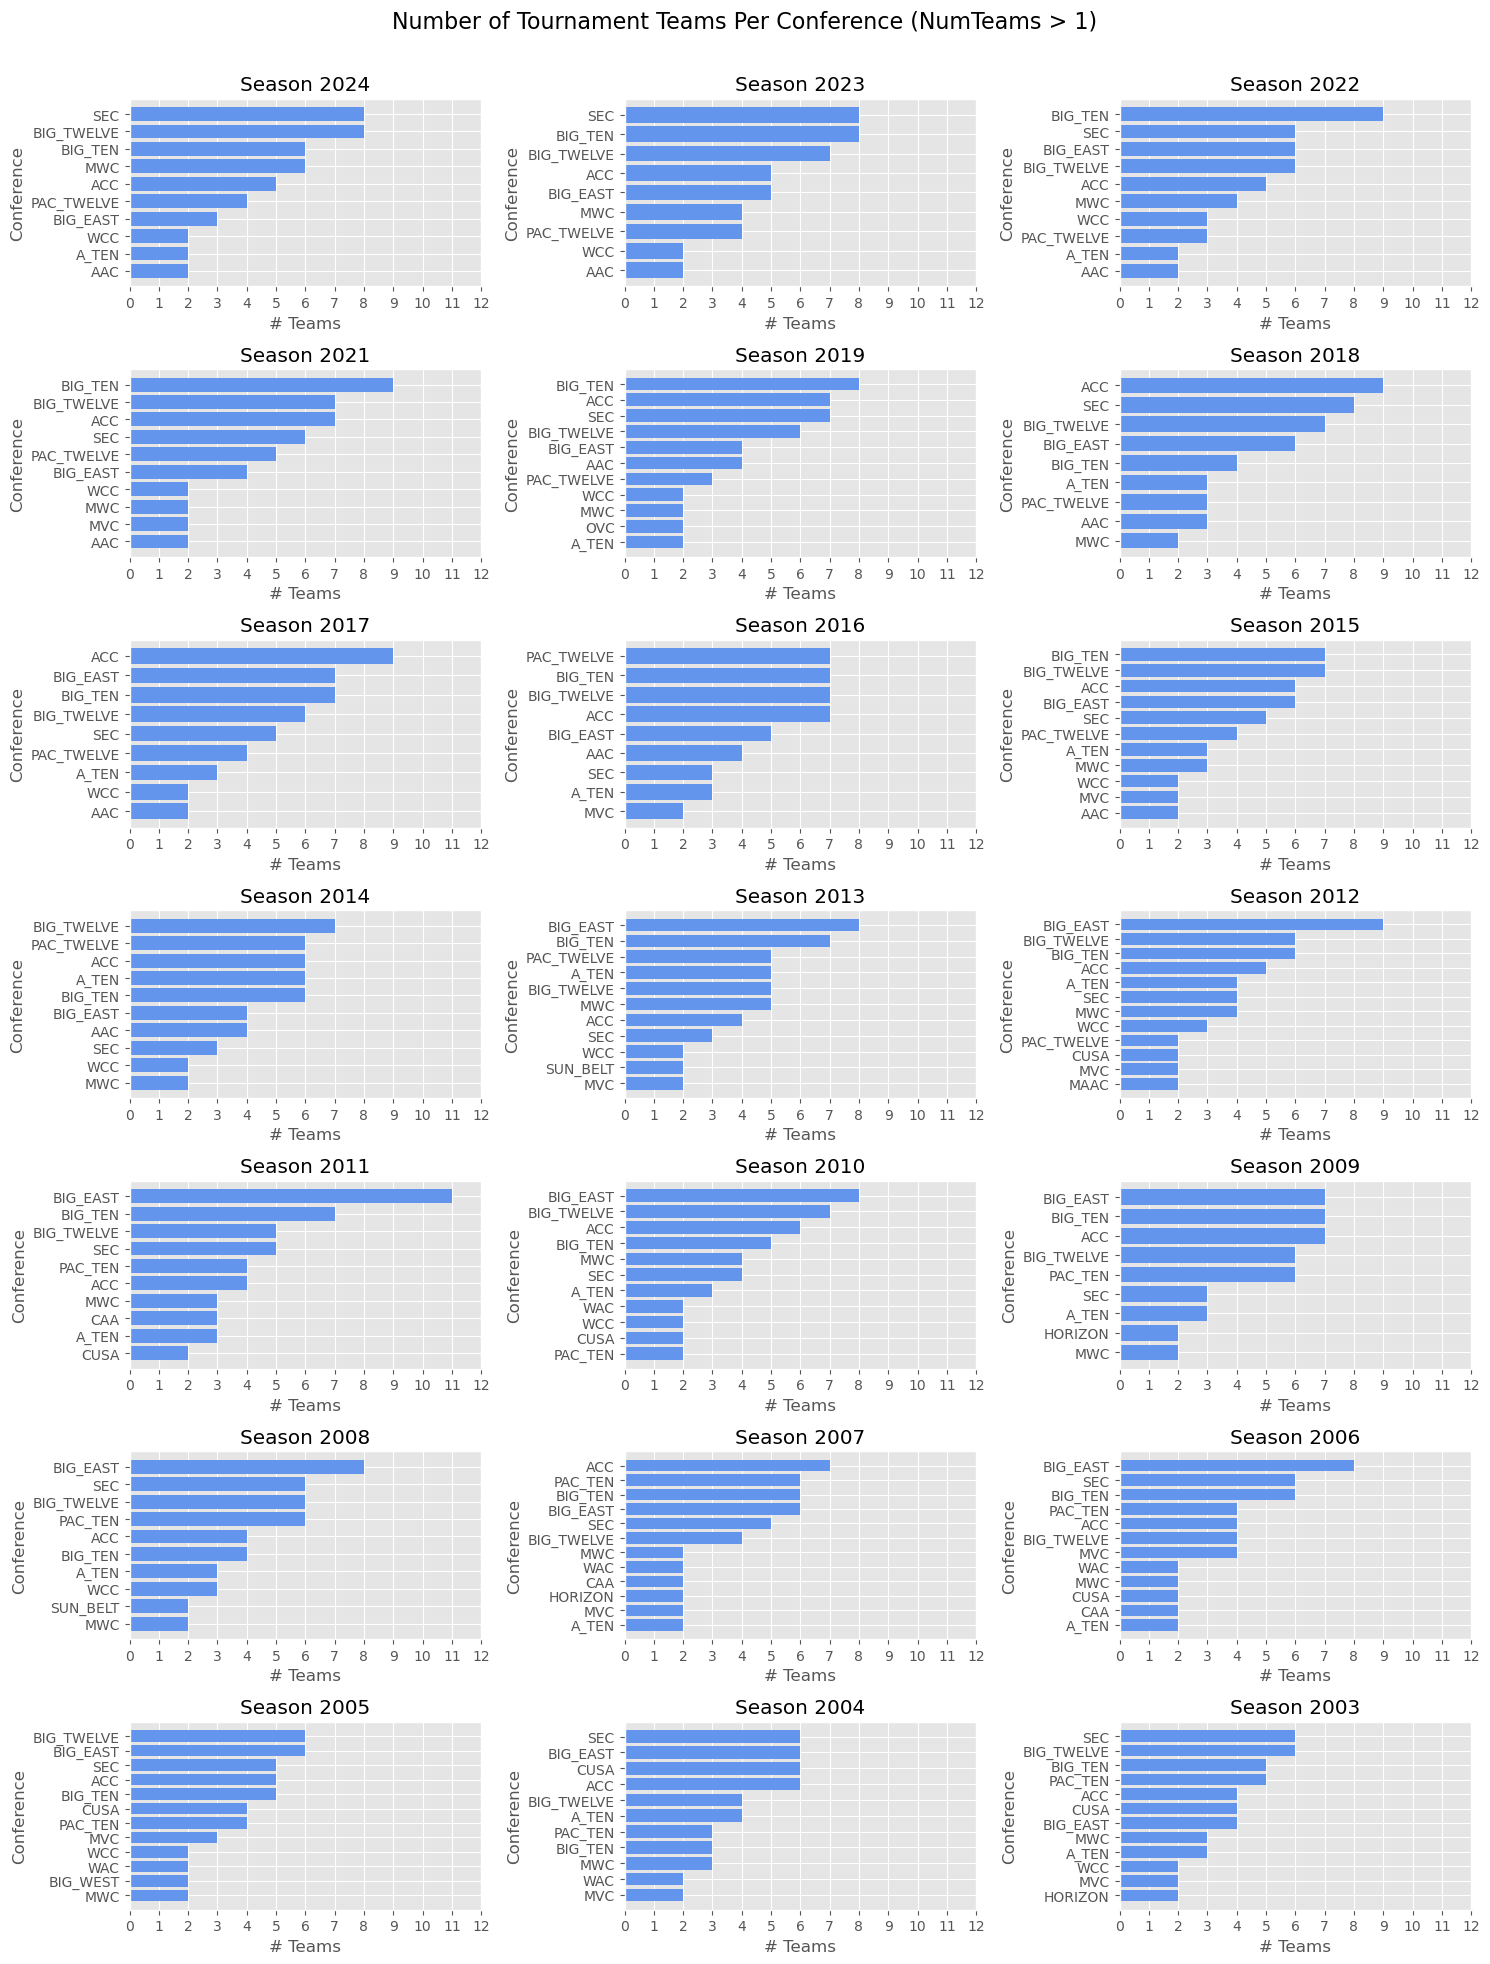

In [ ]:
# Filter to only rows where NumTeams > n to declutter plot
n = 1
filtered = teams_per_conf_season[teams_per_conf_season["NumTeams"] > 1]

# Get unique seasons (Note: no 2020 due to COVID)
seasons = sorted(filtered["Season"].unique(), reverse=True)
max_teams = filtered["NumTeams"].max()

# Create subplots
rows, cols = 7, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 20))
axes = axes.flatten()

# Loop through each season and create a horizontal bar chart
for i, season in enumerate(seasons):
    ax = axes[i]
    season_data = filtered[filtered["Season"] == season].sort_values("NumTeams", ascending=True)
    ax.barh(season_data["ConfAbbrev"], season_data["NumTeams"], color="cornflowerblue")

    # Formatting
    ax.set_title(f"Season {season}")
    ax.set_xlabel("# Teams")
    ax.set_ylabel("Conference")
    ax.set_xlim(0, max_teams + 1)
    ax.set_xticks(range(0, max_teams + 2))


plt.suptitle(f"Number of Tournament Teams Per Conference (NumTeams > {n})\n\n", fontsize=16)
plt.tight_layout()
plt.show()

### <a id='toc1_3_2_'></a>[Tournament Representation Over Time: Power vs. Non-Power Conferences](#toc0_)

Although there has been some mix-shift among the top conferences over the years, the traditional `Power Conferences` continue to anchor the college basketball landscape. These leagues consistently send multiple teams to the NCAA tournament, reinforcing their dominance and depth of competition.

While individual conference rankings may fluctuate season to season, the presence of conferences like the `Big_Ten`, `Big_12`, and `SEC` at the top remains a constant — a testament to their sustained strength and influence in shaping the tournament field. As seen earlier, the teams in these `Power Conferences` are often the best teams in the nation, both by metrics like KenPom rankings and by actual postseason representation.

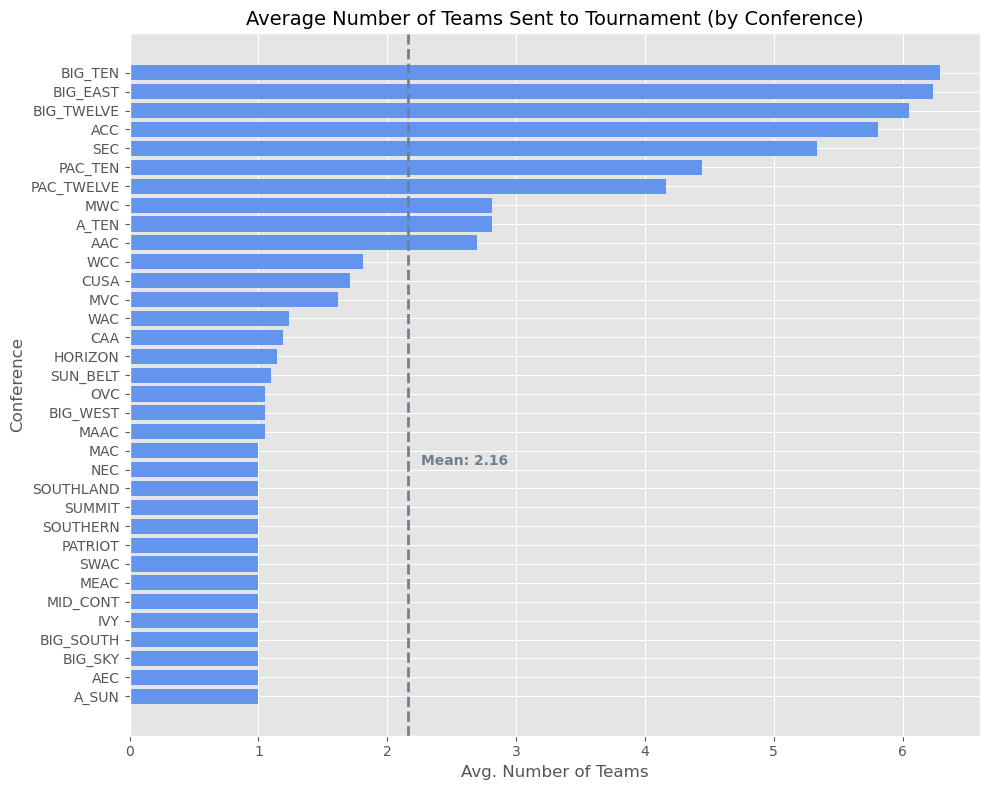

In [ ]:
# Create a horizontal bar chart for average number of teams sent to tournament by conference
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(conf_avg_teams.index, conf_avg_teams.values, color="cornflowerblue")

ax.set_title("Average Number of Teams Sent to Tournament (by Conference)", fontsize=14)
ax.set_xlabel("Avg. Number of Teams")
ax.set_ylabel("Conference")

# Plot mean and format data label
ax.axvline(conf_avg_teams.values.mean(), color='slategrey', linestyle='--', linewidth=2)
ax.text(overall_avg + 0.1, 12.25, f"Mean: {overall_avg:.2f}",
        color='slategrey', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [43]:
conf_avg_teams_df = conf_avg_teams.reset_index()
conf_avg_teams_df.columns = ['ConfAbbrev', 'AvgTeams']

In [ ]:
power_conferences = ['BIG_TEN', 'BIG_TWELVE', 'SEC', 'ACC', 'BIG_EAST', 'PAC_TEN', 'PAC_TWELVE']

# Map ConferenceType (Power / Non-Power)
conf_avg_teams_df['ConferenceType'] = conf_avg_teams_df['ConfAbbrev'].apply(
    lambda x: 'Power' if x in power_conferences else 'Non-Power'
)

# Group by ConferenceType and calculate the mean
power_non_power_avg = conf_avg_teams_df.groupby('ConferenceType')['AvgTeams'].mean()

print(power_non_power_avg)

ConferenceType
Non-Power    1.306349
Power        5.475057
Name: AvgTeams, dtype: float64


### <a id='toc1_3_3_'></a>[Tournament Representation / Team Composition](#toc0_)
The above chart highlights the average number of teams sent to the tournament by each conference. The dominance of the `BIG_TEN`, `BIG_EAST`, `BIG_TWELVE`, and other traditional power conferences is immediately apparent, with these leagues regularly securing multiple bids each year.

Given the structure of automatic bids and at-large selections, larger `"Power Conferences"` often send significantly more teams to the NCAA tournament compared to mid-major conferences, which typically send just one team — their conference champion. Power conferences benefit from greater depth of talent, stronger strength of schedule, and increased exposure to high-quality opponents, which heavily influence at-large bid selection and tournament seeding.

For analysis, this distinction is critical. Two teams with identical records (e.g., 25–5) may look similar on paper but play in vastly different contexts. A `BIG_TEN` team endures a rigorous, ranked-heavy schedule, while an `A_SUN` team likely faces much weaker opposition. What seems like an even comparison is, in reality, apples to oranges.

***
## <a id='toc1_4_'></a>[Model Preparation](#toc0_)
***

## <a id='toc1_5_'></a>[Model Preparation: Defining Conference Type](#toc0_)
Rather than encode each conference individually in our modeling data, we can leverage the predefined `"ConferenceType"` feature to create a `"PowerConference"` feature— a binary indicator of whether a team belongs to a traditional power conference or non-power conference. This simplifies the representation while preserving a meaningful distinction in program strength and competitive environment.

Though the landscape of what qualifies as a power conference can be somewhat subjective, the data offers a clear breakpoint. On average, the `PAC_TWELVE` sends approximately 4.17 teams per season, while the next closest conference, `A_TEN`, averages just 2.81 — a 31% relative drop. This represents the largest gap in average bids between any two adjacent conferences in the ranked distribution.

From a statistical perspective, this "elbow" in the distribution suggests a natural inflection point. Conferences above this threshold consistently field multiple at-large teams and operate with materially stronger competitive profiles. Notably, this cutoff directly aligns with the same seven (7) conferences that emerged earlier in our regular season analysis — reinforcing the validity of this grouping across both regular season and tournament lenses. Therefore, we can reasonably classify the following seven as `Power Conferences`:

- `Big_Ten`
- `Big_Twelve`
- `SEC`
- `ACC`
- `Big_East`
- `Pac_Ten`
- `Pac_Twelve`

This categorization not only simplifies our modeling process but also aligns with observed patterns in both regular season and tournament performance. We'll use this feature to help the model contextualize team strength more effectively, especially when comparing teams across very different competitive landscapes.

In [ ]:
power_conferences = ['Big_Ten', 'BIG_TWELVE', 'SEC', 'ACC', 'Big_East', 'Pac_Ten', 'Pac_Twelve']

# # Tag conferences a power conferences
tournament_df['PowerConference'] = (tournament_df['ConferenceType'] == 'Power').astype(int)
tournament_df['Opp_PowerConference'] = (tournament_df['ConferenceType_Opp'] == 'Power').astype(int)

In [ ]:
# Drop conferences and conference descriptions
tournament_df = tournament_df.drop(columns=['ConfAbbrev', 'Description', 'ConfAbbrev_Opp', 'Description_Opp'])
tournament_df

In [40]:
object_cols = tournament_df.select_dtypes(include=['object']).columns.tolist()
tournament_df[object_cols]

,TeamID,OppTeamID,GameResult,TeamName,OppTeamName,ConfAbbrev,Description,ConfAbbrev_Opp,Description_Opp,Era,ConferenceType,Seed,Region,Era_Opp,ConferenceType_Opp,Seed_Opp,Region_Opp
0,1411,1421,L,TX Southern,UNC Asheville,SWAC,Southwest Athletic Conference,BIG_SOUTH,Big South Conference,Pre-2016,Non-Power,X16a,X,Pre-2016,Non-Power,X16b,X
1,1421,1411,W,UNC Asheville,TX Southern,BIG_SOUTH,Big South Conference,SWAC,Southwest Athletic Conference,Pre-2016,Non-Power,X16b,X,Pre-2016,Non-Power,X16a,X
2,1112,1436,W,Arizona,Vermont,PAC_TEN,Pacific-10 Conference,AEC,America East Conference,Pre-2016,Power,Z01,Z,Pre-2016,Non-Power,Z16,Z
3,1113,1272,W,Arizona St,Memphis,PAC_TEN,Pacific-10 Conference,CUSA,Conference USA,Pre-2016,Power,Z10,Z,Pre-2016,Non-Power,Z07,Z
4,1140,1163,L,BYU,Connecticut,MWC,Mountain West Conference,BIG_EAST,Big East Conference,Pre-2016,Non-Power,X12,X,Pre-2016,Power,X05,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,1163,1104,W,Connecticut,Alabama,BIG_EAST,Big East Conference,SEC,Southeastern Conference,Post-2015,Power,W01,W,Post-2015,Power,X04,X
2760,1301,1345,L,NC State,Purdue,ACC,Atlantic Coast Conference,BIG_TEN,Big Ten Conference,Post-2015,Power,Z11,Z,Post-2015,Power,Y01,Y
2761,1345,1301,W,Purdue,NC State,BIG_TEN,Big Ten Conference,ACC,Atlantic Coast Conference,Post-2015,Power,Y01,Y,Post-2015,Power,Z11,Z
2762,1163,1345,W,Connecticut,Purdue,BIG_EAST,Big East Conference,BIG_TEN,Big Ten Conference,Post-2015,Power,W01,W,Post-2015,Power,Y01,Y


At this stage, we’ll drop the remaining non-numeric columns from the dataset. Identifiers like `TeamName` and `TeamID` don't contain predictive power and introduce unintended noise in the modeling phase. Removing them ensures the model is trained strictly on meaningful, quantitative features.

In [41]:
tournament_df = tournament_df.drop(columns=object_cols)

In [42]:
# Checkpoint - Save df to csv
tournament_df.to_csv('./Data/Live/TournamentMatchupData.csv', index=False)